# Prepare robots first  
* run panda repeater on controller pc  

```
ssh panda@192.168.0.172
roslaunch panda_ros_repeater joint_velocity_repeater.launch robot_ip:=192.168.0.13 load_gripper:=false

```

* Keep indy connected to conty to bypass conty-connection delay bug

# initialize notebook

In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))
import matplotlib.pyplot as plt

# Initialize constants

In [2]:
from pkg.marker_config import *
from pkg.constraint_graph import *
from pkg.constraint.constraint_action import *
from pkg.constraint.constraint_object import *
from pkg.constants import *
from pkg.utils.plot_utils import *
from pkg.utils.utils import *
from pkg.environment_builder import *
from pkg.ui.ui_broker import *
from pkg.controller.combined_robot import *

gtimer = GlobalTimer.instance()
gtimer.reset()

USE_CAM = False
VISUALIZE = True
crob = CombinedRobot(connection_list=(False, False))

connection_list
(False, False)


In [3]:
WDH_MIN_RBT = (0.75, 0.75, 0.5)
WDH_MAX_RBT = (2.25, 2.25, 1.0)
H_MEAN = np.mean([WDH_MAX_RBT[2], WDH_MIN_RBT[2]])
Nwdh = (15,15,15)
L_CELL= 0.2

joint_num = crob.joint_num

N_vtx_box = 3*8
N_mask_box = 1
N_joint_box = joint_num
N_label_box = N_vtx_box+N_mask_box+N_joint_box
N_vtx_cyl = 3*2+1
N_mask_cyl = 1
N_joint_cyl = joint_num
N_label_cyl = N_vtx_cyl+N_mask_cyl+N_joint_cyl
N_vtx_init = 3*8
N_mask_init = 1
N_joint_init = joint_num
N_label_init = N_vtx_init+N_mask_init+N_joint_init
N_vtx_goal = 3*8
N_mask_goal = 1
N_joint_goal = joint_num
N_label_goal = N_vtx_goal+N_mask_goal+N_joint_goal
N_joint_label = 9*joint_num
N_cell_label = N_label_box+N_label_cyl+N_label_init+N_label_goal + N_joint_label
N_BEGIN_CYL = N_vtx_box+N_mask_box+N_joint_box
N_BEGIN_INIT = N_BEGIN_CYL+N_vtx_cyl+N_mask_cyl+N_joint_cyl
N_BEGIN_GOAL = N_BEGIN_INIT+N_vtx_init+N_mask_init+N_joint_init

# initialize graph & ui

In [4]:
if "cam" not in locals():
    
    cam = StereoCamera.instance() if USE_CAM else None

# set urdf
xcustom, JOINT_NAMES, LINK_NAMES, urdf_content = set_custom_robots(crob.robots_on_scene, XYZ_RPY_ROBOTS_DEFAULT, crob.custom_limits, start_rviz=True)
ghnd = GeometryHandle(urdf_content)


graph = ConstraintGraph(ghnd=ghnd, urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES, 
                        urdf_content=urdf_content, combined_robot=crob)
graph.set_camera(cam)
graph.set_cam_robot_collision(_add_cam_poles=USE_CAM)
graph.set_rviz()

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(graph)
ui_broker.start_server()

# set rviz
graph.set_rviz(crob.home_pose)
ui_broker.set_tables()

Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.


Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


In [5]:
1

1

# Prepare shm, functions

In [6]:
import numpy as np
import SharedArray as sa

# Attach it as a different array. This can be done from another
# python interpreter as long as it runs on the same computer.
scene_base_data_p = sa.attach("shm://scene_base_data")
scene_base_batch_p = sa.attach("shm://scene_base_batch")
cell_init_p = sa.attach("shm://cell_init")
verts_init_p = sa.attach("shm://verts_init")
chain_init_p = sa.attach("shm://chain_init")
cell_goal_p = sa.attach("shm://cell_goal")
verts_goal_p = sa.attach("shm://verts_goal")
chain_goal_p = sa.attach("shm://chain_goal")
result_p = sa.attach("shm://result")
data_sent_p = sa.attach("shm://data_sent")
result_sent_p = sa.attach("shm://result_sent")

In [7]:
 def get_action_boxes(graph, from_state, to_state, redundancy_dict, mplan=None, L_CELL=0.2, Nwdh=(15,15,15), BASE_LINK='base_link', center_height=0.75):
    if mplan is None:
        mplan = graph.planner
    graph.set_object_state(from_state)
    binding_list = graph.get_slack_bindings(from_state, to_state)
    obj_name, ap_name, binder_name = binding_list[0]
    redundancy = redundancy_dict[obj_name] if redundancy_dict else None
    self, group_name_handle, group_name_binder = mplan, None, None
    binder = self.binder_dict[binder_name]
    obj = self.object_dict[obj_name]
    handle = obj.action_points_dict[ap_name]
    point_add, rpy_add = calc_redundancy(redundancy, binder)
    T_handle = handle.Toff_lh
    T_binder = np.matmul(binder.Toff_lh, SE3(Rot_rpy(rpy_add), point_add))
    if len(self.planner.group_names)==1:
        group_name_handle = self.planner.group_names if handle.object.link_name in self.urdf_content.parent_map else []
        group_name_binder = self.planner.group_names if binder.object.link_name in self.urdf_content.parent_map else []
    else:
        group_name_handle = group_name_handle or [gname for gname in self.planner.group_names if gname in handle.object.link_name]
        group_name_binder = group_name_binder or [gname for gname in self.planner.group_names if gname in binder.object.link_name]

    if group_name_binder and not group_name_handle:
        group_name = group_name_binder[0]
        tool, T_tool = binder, T_binder
        target, T_tar = handle, T_handle
    elif group_name_handle and not group_name_binder:
        group_name = group_name_handle[0]
        tool, T_tool = handle, T_handle
        target, T_tar = binder, T_binder
    else:
        print(binder.name, obj.object.name)
        print(group_name_binder, group_name_handle)
        print("uncontrollable binding")
        raise(RuntimeError("uncontrollable binding"))
    #     return [], [0]*self.planner.joint_num, None, False

    T_tar_tool = np.matmul(T_tar, SE3_inv(T_tool))
    goal_pose = tuple(T_tar_tool[:3,3]) \
                +tuple(Rotation.from_dcm(T_tar_tool[:3,:3]).as_quat())

    CENTER_OFFSET = tuple(np.multiply(Nwdh[:2], L_CELL) / 2)+(center_height,)
    T_ho = SE3_inv(target.Toff_oh)
    T_tar_o = np.matmul(get_tf(target.object.link_name, Q_dict, self.urdf_content), np.matmul(T_tar, T_ho))
    T_tool_o = np.matmul(get_tf(tool.object.link_name, Q_dict, self.urdf_content), np.matmul(T_tool, T_ho))

    T_tar_o[:3,3]+= CENTER_OFFSET
    T_tool_o[:3,3]+= CENTER_OFFSET

    cell_init, verts_init = get_cell_verts(GEOTYPE.BOX, T_tool_o, obj.object.dims, L_CELL, Nwdh)
    chain_init = chain_dict[tool.object.link_name]
    cell_goal, verts_goal = get_cell_verts(GEOTYPE.BOX, T_tar_o, obj.object.dims, L_CELL, Nwdh)
    chain_goal = chain_dict[target.object.link_name]
    return cell_init, verts_init, chain_init, cell_goal, verts_goal, chain_goal

# Test loaded data

## get list

In [10]:
GLOBAL_FILENAME = "global.json"
WORLD_FILENAME = "world.json"
SCENE_FILENAME = "scene.json"
DATA_PATH = "./data"
CONVERTED_PATH = "./data/converted/"
DATASET_LIST = ['20201214-165211', '20201216-021416', '20201218-024611']
data_list = []
N_data = 0
# ## Load Global params
for DATASET in DATASET_LIST:
    CURRENT_PATH = os.path.join(DATA_PATH, DATASET)
    CURRENT_PATH_CONVERTED = os.path.join(CONVERTED_PATH, DATASET)
    # ## Load world
    WORLD_LIST = sorted(filter(lambda x: not x.endswith(".json"), os.listdir(CURRENT_PATH_CONVERTED)))
    for WORLD in WORLD_LIST:
            WORLD_PATH = os.path.join(CURRENT_PATH, WORLD)
            WORLD_PATH_CONVERTED = os.path.join(CURRENT_PATH_CONVERTED, WORLD)
            # ## Load scene
            SCENE_LIST = sorted(filter(lambda x: not x.endswith(".json"), os.listdir(WORLD_PATH_CONVERTED)))
            for SCENE in SCENE_LIST:
                SCENE_PATH = os.path.join(WORLD_PATH, SCENE)
                SCENE_PATH_CONVERTED = os.path.join(WORLD_PATH_CONVERTED, SCENE)
                # ## Load action
                ACTION_LIST = sorted(filter(lambda x: x != SCENE_FILENAME, os.listdir(SCENE_PATH)))
                for ACTION in ACTION_LIST:
                    N_action = len(load_json(os.path.join(SCENE_PATH, ACTION)))
                    N_data += N_action
                    for i_act in range(N_action):
                        data_list.append((DATASET, WORLD, SCENE, ACTION, i_act))

## get data

```
DATASET, WORLD, SCENE, ACTION, i_act = ('20201214-165211',
 'WORLD-20201214-180946',
 'SCENE-20201214-180948',
 '20201214-181012.json',
 1)
```

In [11]:
DATASET, WORLD, SCENE, ACTION, i_act = random.choice(data_list)
# DATASET, WORLD, SCENE, ACTION, i_act = ('20201214-165211',  'WORLD-20201214-180946',  'SCENE-20201214-180948',  '20201214-181012.json', 1)
# DATASET, WORLD, SCENE, ACTION, i_act = ('./data/converted/', '20201216-021416', 'WORLD-20201216-052332', 'SCENE-20201216-052334')

scene_data, success, skey = load_scene_data(CONVERTED_PATH, DATASET, WORLD, SCENE, ACTION.replace(".json","-%03d.pkl"%i_act), crob.joint_num)
print(success)

## send data scene
np.copyto(scene_base_data_p, scene_data)

load: ('./data/converted/', '20201218-024611', 'WORLD-20201218-041907', 'SCENE-20201218-041909')
False


In [12]:
TEST_OFFSET_X_LIST = [0]
N_test = len(TEST_OFFSET_X_LIST)
TEST_OFFSET_RES_LIST = []
for i_test, TEST_OFFSET_X in enumerate(TEST_OFFSET_X_LIST):
    SAMPLED_DATA = defaultdict(dict)
    MODEL_OFFSET_TEST = (1.5,1.5,0.75)

    #  GLOBAL
    CURRENT_PATH = os.path.join(DATA_PATH, DATASET)

    ## Load global params
    GLOBAL_PARAMS = load_json(os.path.join(CURRENT_PATH, GLOBAL_FILENAME))
    WDH = GLOBAL_PARAMS["WDH"]
    L_CELL = GLOBAL_PARAMS["L_CELL"]
    RATIO_DIMS = GLOBAL_PARAMS["RATIO_DIMS"]
    REACH_OFFSET_DICT = GLOBAL_PARAMS["REACH_OFFSET_DICT"]
    GRIPPER_REFS = GLOBAL_PARAMS["GRIPPER_REFS"]
    BASE_LINK = GLOBAL_PARAMS["BASE_LINK"]
    S_F_RATIO = GLOBAL_PARAMS["S_F_RATIO"]
    TIMEOUT = GLOBAL_PARAMS["TIMEOUT"]

    CENTER = tuple(np.divide(WDH, 2, dtype=np.float))
    Ws, Ds, Hs = WDH
    Nw, Nd, Nh = Nwdh = int(Ws / L_CELL), int(Ds / L_CELL), int(Hs / L_CELL)
    L_MAX = L_CELL * RATIO_DIMS
    print("scene size: {} ({},{},{})".format(Nw * Nd * Nh, Nw, Nd, Nh))

    # WORLD
    WORLD_PATH = os.path.join(CURRENT_PATH, WORLD)
    SAMPLED_DATA["WORLD"] = load_json(os.path.join(WORLD_PATH, WORLD_FILENAME))
    Trbt_dict = SAMPLED_DATA["WORLD"]["Trbt_dict"]
    for rkey in Trbt_dict:
        Trbt_dict[rkey][0] = np.subtract(Trbt_dict[rkey][0], MODEL_OFFSET_TEST)
    reach_center_dict = {k: tuple(np.add(v[0], REACH_OFFSET_DICT[k])) for k, v in Trbt_dict.items()}

    cam = None
    # set urdf
    xcustom, JOINT_NAMES, LINK_NAMES, urdf_content = set_custom_robots(crob.robots_on_scene, Trbt_dict,
                                                                       crob.custom_limits, start_rviz=VISUALIZE)
    ghnd = GeometryHandle(urdf_content)
    if VISUALIZE: time.sleep(2)

    # set graph
    graph = ConstraintGraph(ghnd=ghnd, urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES,
                            urdf_content=urdf_content, combined_robot=crob)
    graph.set_camera(cam)
    graph.set_cam_robot_collision(_add_cam_poles=False, color=(1, 1, 0, 0.3))
    if VISUALIZE: graph.set_rviz()

    # start UI
    ui_broker = UIBroker.instance()
    ui_broker.initialize(graph)
    ui_broker.start_server()

    # set rviz
    if VISUALIZE: graph.set_rviz(crob.home_pose)
    ui_broker.set_tables()

    for gripper in GRIPPER_REFS.values():
        graph.register_binder(name=gripper['bname'], _type=FramedTool, point=gripper['tcp_ref'], rpy=[0, 0, 0],
                              link_name=gripper['link_name'])
    graph.register_binder(name='base', _type=PlaceFrame, point=[0, 0, 0], rpy=[0, 0, 0], link_name=BASE_LINK)
    vtem = graph.ghnd.create_safe(name="virtual", gtype=GEOTYPE.SPHERE, link_name=BASE_LINK,
                                  dims=(0, 0, 0), center=(0, 0, 0), rpy=(0, 0, 0), collision=False, display=False
                                  )
    graph.add_object("virtual",
                     SingleHandleObject(_object=vtem,
                                        action_point=FramePoint(name="point", _object=vtem, point=(0, 0, 0),
                                                                rpy=(0, 0, 0), name_full=None)),
                     binding=("point", "base"))

    obj_list = []
    col_obj_list = []

    # SCENE
    SCENE_PATH = os.path.join(WORLD_PATH, SCENE)
    SAMPLED_DATA["SCENE"] = load_json(os.path.join(SCENE_PATH, SCENE_FILENAME))
    Q_s = np.array(SAMPLED_DATA["SCENE"]["Q_s"])
    Q_s, links, link_verts, link_ctems, link_rads = sample_joint(graph, Q_s_loaded=Q_s)
    Q_s_dict = SAMPLED_DATA["SCENE"]["Q_s_dict"]
    obj_dat = SAMPLED_DATA["SCENE"]["obj_dat"]

    if VISUALIZE:
        graph.show_pose(Q_s)
        time.sleep(1)
        graph.show_pose(Q_s)
        time.sleep(1)
        graph.show_pose(Q_s)
    for obj in obj_list: graph.remove_geometry(obj)
    for odat in obj_dat:
        nbox, gtype, dims, color, center, rpy = odat["nbox"], getattr(GEOTYPE, odat["gtype"]), odat["dims"], \
                                                odat["color"], odat["center"], odat["rpy"]
        center = np.subtract(center, MODEL_OFFSET_TEST)
        obj = graph.ghnd.create_safe(
            name="{}_{}_{}_{}".format(gtype.name, *nbox), link_name=BASE_LINK, gtype=gtype,
            center=center, rpy=rpy, dims=dims, color=color, display=True, collision=True, fixed=True)
        obj_list.append(obj)
        graph.add_marker(obj, vis=VISUALIZE)

    for obj in col_obj_list: graph.remove_geometry(obj)

    if VISUALIZE: graph.set_rviz()
    dcol = DataCollector(graph, GRIPPER_REFS, S_F_RATIO=S_F_RATIO)
    if VISUALIZE: graph.set_rviz()

    # ACTION
    print("[BEGIN] {} - {} - {} - {} ===============".format(DATASET, WORLD, SCENE, ACTION))
    snode_dict_bak = {int(k): v for k, v in load_json(os.path.join(SCENE_PATH, ACTION)).items()}
    dcol.snode_dict = dcol.manager.dict()
    for k, v in snode_dict_bak.items():
        dcol.snode_dict[k] = deepcopy(v)
    snode_keys = sorted(snode_dict_bak.keys())

    if i_act not in snode_keys:
        raise(RuntimeError("i_act not in snode_keys"))

    # snode
    snode = dcol.snode_dict[i_act]
    rname, inhand, obj, tar, dims_bak, color_bak, succ, _ = load_manipulation_from_dict(snode,
                                                                                        graph.ghnd)
    for gtem in [inhand, obj]:
        if gtem.link_name == BASE_LINK:
            gtem.set_offset_tf(center=np.subtract(gtem.center, MODEL_OFFSET_TEST))
            gtem.set_offset_tf(center=np.subtract(gtem.center, (TEST_OFFSET_X,0,0)))

    # action type
    if rname and tar:  # handover case
        action_type = "HANDOVER"
    elif inhand.collision:  # place case
        action_type = "PLACE"
    elif obj.collision:  # pick case
        action_type = "PICK"
    else:
        raise (RuntimeError("non-implemented case"))

    # planners
    if action_type == "HANDOVER":
        dual_mplan_dict = get_dual_planner_dict(GRIPPER_REFS, graph.ghnd, graph.urdf_content, graph.urdf_path,
                                                graph.link_names, graph.combined_robot.robot_names)
    else:
        mplan = MoveitPlanner(joint_names=graph.joint_names, link_names=graph.link_names, urdf_path=graph.urdf_path,
                              urdf_content=graph.urdf_content,
                              robot_names=graph.combined_robot.robot_names,
                              binder_links=[v.object.link_name for v in graph.binder_dict.values()],
                              ghnd=graph.ghnd)

    # plan
    if rname and tar:  # handover case
        remove_map = [[], [0, 1]]
        action_type = "HANDOVER"
        trajectory, Q_last, error, success_now = test_handover(graph, GRIPPER_REFS, rname, inhand,
                                                               obj, tar, Q_s,
                                                               dual_mplan_dict[(rname, tar)], timeout=TIMEOUT)
        state_s, state_g = get_handover_states(graph, GRIPPER_REFS, rname, inhand, obj, tar, Q_s)
    elif inhand.collision:  # place case
        remove_map = [[], [0, 1]]
        action_type = "PLACE"
        trajectory, Q_last, error, success_now = test_place(graph, GRIPPER_REFS, rname, inhand, obj,
                                                            tar, Q_s, mplan, timeout=TIMEOUT)
        state_s, state_g = get_place_states(graph, GRIPPER_REFS, rname, inhand, obj, tar, Q_s)
    elif obj.collision:  # pick case
        remove_map = [[1], [0]]
        action_type = "PICK"
        trajectory, Q_last, error, success_now = test_pick(graph, GRIPPER_REFS, rname, inhand, obj,
                                                           tar, Q_s, mplan, timeout=TIMEOUT)
        state_s, state_g = get_pick_states(graph, GRIPPER_REFS, rname, inhand, obj, tar, Q_s)
    else:
        remove_map = [[], [0,1]]
        action_type = "None"
        raise (RuntimeError("non-implemented case"))

    if VISUALIZE:
        show_manip_coords(graph, GRIPPER_REFS, action_type, rname, inhand, obj, rname2=tar)
#         graph.show_motion(trajectory, period=0.1)

    print("[END] {} - {} - {} - {} - {} = {} / {} ({}/{})".format(DATASET, WORLD, SCENE, ACTION, i_act, success_now, succ, i_test, N_test), end='\r')
    TEST_OFFSET_RES_LIST.append(success_now)
    
    # convert_send scene
    gtimer.reset()
    gtimer.tic("convert_workspace")
    ghnd_new= graph.convert_workspace(ghnd)
    gtimer.toc("convert_workspace")

    ## remove bases
    exclude_list = ["floor", "wall", "cam"]
    gkeys = sorted(ghnd_new.NAME_DICT.keys())
    for gname in gkeys:
        gtem = ghnd_new.NAME_DICT[gname]
        if np.any([ename in gtem.name for ename in exclude_list]):
            ghnd_new.remove(gtem)
    graph.object_list=[]
    from_state = state_s
    to_state = state_g
    gtimer.tic("convert_scene")
    scene_base_data, ctem_names, ctem_cells, chain_dict = graph.convert_scene(ghnd_new, state=from_state, only_base=False)
    gtimer.toc("convert_scene")
    gtimer.tic("copy_scene_base_data")
    scene_base_batch_p[i_test] = scene_base_data
    gtimer.toc("copy_scene_base_data")
    print(ghnd_new.NAME_DICT.keys())

    # convert_send action
    from pkg.planner.moveit.moveit_planner import MoveitPlanner
    mplan = MoveitPlanner(joint_names=graph.joint_names, link_names=graph.link_names, urdf_path=graph.urdf_path, urdf_content=graph.urdf_content,
                          robot_names=graph.combined_robot.robot_names, binder_links=[v.object.link_name for v in graph.binder_dict.values()], ghnd=graph.ghnd)
    graph.set_planner(mplan)
    from pkg.sampler.object_a_star import *
    sampler = ObjectAstarSampler(graph)
    graph.set_sampler(sampler)
    sampler.build_graph()

    state = from_state
    leaf = sampler.node_dict[state.onode][0]
    Q_dict = list2dict(state.Q, graph.joint_names)

    gtimer.reset()
    cell_init_b, verts_init_b, chain_init_b, cell_goal_b, verts_goal_b, chain_goal_b = [], [], [], [], [], []
    gtimer.tic("get_action_boxes")
    cell_init, verts_init, chain_init, cell_goal, verts_goal, chain_goal = get_action_boxes(
        graph, from_state, to_state, {}, mplan=mplan, L_CELL=0.2, Nwdh=(15,15,15), BASE_LINK='base_link')
    gtimer.toc("get_action_boxes")

    cell_init_p[i_test,:] = cell_init
    verts_init_p[i_test,:] = verts_init
    chain_init_p[i_test,:] = chain_init
    cell_goal_p[i_test,:] = cell_goal
    verts_goal_p[i_test,:] = verts_goal
    chain_goal_p[i_test,:] = chain_goal
if VISUALIZE: graph.show_pose(Q_s)

scene size: 3375 (15,15,15)


Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[BEGIN] 20201218-024611 - WORLD-20201218-041907 - SCENE-20201218-041909 - 20201218-041946.json ===============
ignore BOX_14_7_5 out of workspace1218-041907 - SCENE-20201218-041909 - 20201218-041946.json - 12 = False / False (0/1)
ignore BOX_14_10_2 out of workspace
ignore BOX_14_10_4 out of workspace
['BOX_8_3_4', 'CYLINDER_5_3_7', 'BOX_3_3_10', 'BOX_3_7_3', 'BOX_1_13_5', 'indy0_link5_Cylinder_0', 'BOX_0_8_0', 'panda1_leftfinger_Cylinder_0', 'CYLINDER_11_12_5', 'CYLINDER_8_8_3', 'CYLINDER_12_9_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_11_4_1', 'CYLINDER_3_4_3', 'BOX_4_11_11', 'BOX_7_12_3', 'CYLINDER_13_5_4', 'CYLINDER_5_10_7', 'BOX_5_11_10', 'panda1_rightfinger_Cylinder_0', 'BOX_9_3_6', 'CYLINDER_10_4_8', 'CYLINDER_5_7_4', 'panda1_link2_Cylinder_0', 'BOX_10_10_6', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_9_14_3', 'BOX_12_11_6', 'indy0_tcp_Cylinder_0_1', 'BOX_12_11_5', 'CYLI

## test distance offset

In [76]:
TEST_OFFSET_X_LIST = np.arange(-1.5,-1.5+0.3*12-0.1,0.3)
N_test = len(TEST_OFFSET_X_LIST)
TEST_OFFSET_RES_LIST = []
for i_test, TEST_OFFSET_X in enumerate(TEST_OFFSET_X_LIST):
    SAMPLED_DATA = defaultdict(dict)
    MODEL_OFFSET_TEST = (1.5,1.5,0.75)

    #  GLOBAL
    CURRENT_PATH = os.path.join(DATA_PATH, DATASET)

    ## Load global params
    GLOBAL_PARAMS = load_json(os.path.join(CURRENT_PATH, GLOBAL_FILENAME))
    WDH = GLOBAL_PARAMS["WDH"]
    L_CELL = GLOBAL_PARAMS["L_CELL"]
    RATIO_DIMS = GLOBAL_PARAMS["RATIO_DIMS"]
    REACH_OFFSET_DICT = GLOBAL_PARAMS["REACH_OFFSET_DICT"]
    GRIPPER_REFS = GLOBAL_PARAMS["GRIPPER_REFS"]
    BASE_LINK = GLOBAL_PARAMS["BASE_LINK"]
    S_F_RATIO = GLOBAL_PARAMS["S_F_RATIO"]
    TIMEOUT = GLOBAL_PARAMS["TIMEOUT"]

    CENTER = tuple(np.divide(WDH, 2, dtype=np.float))
    Ws, Ds, Hs = WDH
    Nw, Nd, Nh = Nwdh = int(Ws / L_CELL), int(Ds / L_CELL), int(Hs / L_CELL)
    L_MAX = L_CELL * RATIO_DIMS
    print("scene size: {} ({},{},{})".format(Nw * Nd * Nh, Nw, Nd, Nh))

    # WORLD
    WORLD_PATH = os.path.join(CURRENT_PATH, WORLD)
    SAMPLED_DATA["WORLD"] = load_json(os.path.join(WORLD_PATH, WORLD_FILENAME))
    Trbt_dict = SAMPLED_DATA["WORLD"]["Trbt_dict"]
    for rkey in Trbt_dict:
        Trbt_dict[rkey][0] = np.subtract(Trbt_dict[rkey][0], MODEL_OFFSET_TEST)
    reach_center_dict = {k: tuple(np.add(v[0], REACH_OFFSET_DICT[k])) for k, v in Trbt_dict.items()}

    cam = None
    # set urdf
    xcustom, JOINT_NAMES, LINK_NAMES, urdf_content = set_custom_robots(crob.robots_on_scene, Trbt_dict,
                                                                       crob.custom_limits, start_rviz=VISUALIZE)
    ghnd = GeometryHandle(urdf_content)
    if VISUALIZE: time.sleep(2)

    # set graph
    graph = ConstraintGraph(ghnd=ghnd, urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES,
                            urdf_content=urdf_content, combined_robot=crob)
    graph.set_camera(cam)
    graph.set_cam_robot_collision(_add_cam_poles=False, color=(1, 1, 0, 0.3))
    if VISUALIZE: graph.set_rviz()

    # start UI
    ui_broker = UIBroker.instance()
    ui_broker.initialize(graph)
    ui_broker.start_server()

    # set rviz
    if VISUALIZE: graph.set_rviz(crob.home_pose)
    ui_broker.set_tables()

    for gripper in GRIPPER_REFS.values():
        graph.register_binder(name=gripper['bname'], _type=FramedTool, point=gripper['tcp_ref'], rpy=[0, 0, 0],
                              link_name=gripper['link_name'])
    graph.register_binder(name='base', _type=PlaceFrame, point=[0, 0, 0], rpy=[0, 0, 0], link_name=BASE_LINK)
    vtem = graph.ghnd.create_safe(name="virtual", gtype=GEOTYPE.SPHERE, link_name=BASE_LINK,
                                  dims=(0, 0, 0), center=(0, 0, 0), rpy=(0, 0, 0), collision=False, display=False
                                  )
    graph.add_object("virtual",
                     SingleHandleObject(_object=vtem,
                                        action_point=FramePoint(name="point", _object=vtem, point=(0, 0, 0),
                                                                rpy=(0, 0, 0), name_full=None)),
                     binding=("point", "base"))

    obj_list = []
    col_obj_list = []

    # SCENE
    SCENE_PATH = os.path.join(WORLD_PATH, SCENE)
    SAMPLED_DATA["SCENE"] = load_json(os.path.join(SCENE_PATH, SCENE_FILENAME))
    Q_s = np.array(SAMPLED_DATA["SCENE"]["Q_s"])
    Q_s, links, link_verts, link_ctems, link_rads = sample_joint(graph, Q_s_loaded=Q_s)
    Q_s_dict = SAMPLED_DATA["SCENE"]["Q_s_dict"]
    obj_dat = SAMPLED_DATA["SCENE"]["obj_dat"]

    if VISUALIZE:
        graph.show_pose(Q_s)
        time.sleep(1)
        graph.show_pose(Q_s)
        time.sleep(1)
        graph.show_pose(Q_s)
    for obj in obj_list: graph.remove_geometry(obj)
    for odat in obj_dat:
        nbox, gtype, dims, color, center, rpy = odat["nbox"], getattr(GEOTYPE, odat["gtype"]), odat["dims"], \
                                                odat["color"], odat["center"], odat["rpy"]
        center = np.subtract(center, MODEL_OFFSET_TEST)
        obj = graph.ghnd.create_safe(
            name="{}_{}_{}_{}".format(gtype.name, *nbox), link_name=BASE_LINK, gtype=gtype,
            center=center, rpy=rpy, dims=dims, color=color, display=True, collision=True, fixed=True)
        obj_list.append(obj)
        graph.add_marker(obj, vis=VISUALIZE)

    for obj in col_obj_list: graph.remove_geometry(obj)

    if VISUALIZE: graph.set_rviz()
    dcol = DataCollector(graph, GRIPPER_REFS, S_F_RATIO=S_F_RATIO)
    if VISUALIZE: graph.set_rviz()

    # ACTION
    print("[BEGIN] {} - {} - {} - {} ===============".format(DATASET, WORLD, SCENE, ACTION))
    snode_dict_bak = {int(k): v for k, v in load_json(os.path.join(SCENE_PATH, ACTION)).items()}
    dcol.snode_dict = dcol.manager.dict()
    for k, v in snode_dict_bak.items():
        dcol.snode_dict[k] = deepcopy(v)
    snode_keys = sorted(snode_dict_bak.keys())

    if i_act not in snode_keys:
        raise(RuntimeError("i_act not in snode_keys"))

    # snode
    snode = dcol.snode_dict[i_act]
    rname, inhand, obj, tar, dims_bak, color_bak, succ, _ = load_manipulation_from_dict(snode,
                                                                                        graph.ghnd)
    for gtem in [inhand, obj]:
        if gtem.link_name == BASE_LINK:
            gtem.set_offset_tf(center=np.subtract(gtem.center, MODEL_OFFSET_TEST))
            gtem.set_offset_tf(center=np.subtract(gtem.center, (TEST_OFFSET_X,0,0)))

    # action type
    if rname and tar:  # handover case
        action_type = "HANDOVER"
    elif inhand.collision:  # place case
        action_type = "PLACE"
    elif obj.collision:  # pick case
        action_type = "PICK"
    else:
        raise (RuntimeError("non-implemented case"))

    # planners
    if action_type == "HANDOVER":
        dual_mplan_dict = get_dual_planner_dict(GRIPPER_REFS, graph.ghnd, graph.urdf_content, graph.urdf_path,
                                                graph.link_names, graph.combined_robot.robot_names)
    else:
        mplan = MoveitPlanner(joint_names=graph.joint_names, link_names=graph.link_names, urdf_path=graph.urdf_path,
                              urdf_content=graph.urdf_content,
                              robot_names=graph.combined_robot.robot_names,
                              binder_links=[v.object.link_name for v in graph.binder_dict.values()],
                              ghnd=graph.ghnd)

    # plan
    if rname and tar:  # handover case
        remove_map = [[], [0, 1]]
        action_type = "HANDOVER"
        trajectory, Q_last, error, success_now = test_handover(graph, GRIPPER_REFS, rname, inhand,
                                                               obj, tar, Q_s,
                                                               dual_mplan_dict[(rname, tar)], timeout=TIMEOUT)
        state_s, state_g = get_handover_states(graph, GRIPPER_REFS, rname, inhand, obj, tar, Q_s)
    elif inhand.collision:  # place case
        remove_map = [[], [0, 1]]
        action_type = "PLACE"
        trajectory, Q_last, error, success_now = test_place(graph, GRIPPER_REFS, rname, inhand, obj,
                                                            tar, Q_s, mplan, timeout=TIMEOUT)
        state_s, state_g = get_place_states(graph, GRIPPER_REFS, rname, inhand, obj, tar, Q_s)
    elif obj.collision:  # pick case
        remove_map = [[1], [0]]
        action_type = "PICK"
        trajectory, Q_last, error, success_now = test_pick(graph, GRIPPER_REFS, rname, inhand, obj,
                                                           tar, Q_s, mplan, timeout=TIMEOUT)
        state_s, state_g = get_pick_states(graph, GRIPPER_REFS, rname, inhand, obj, tar, Q_s)
    else:
        remove_map = [[], [0,1]]
        action_type = "None"
        raise (RuntimeError("non-implemented case"))

    if VISUALIZE:
        show_manip_coords(graph, GRIPPER_REFS, action_type, rname, inhand, obj, rname2=tar)
#         graph.show_motion(trajectory, period=0.1)

    print("[END] {} - {} - {} - {} - {} = {} / {} ({}/{})".format(DATASET, WORLD, SCENE, ACTION, i_act, success_now, succ, i_test, N_test), end='\r')
    TEST_OFFSET_RES_LIST.append(success_now)
    
    # convert_send scene
    gtimer.reset()
    gtimer.tic("convert_workspace")
    ghnd_new= graph.convert_workspace(ghnd)
    gtimer.toc("convert_workspace")

    ## remove bases
    exclude_list = ["floor", "wall", "cam"]
    gkeys = sorted(ghnd_new.NAME_DICT.keys())
    for gname in gkeys:
        gtem = ghnd_new.NAME_DICT[gname]
        if np.any([ename in gtem.name for ename in exclude_list]):
            ghnd_new.remove(gtem)
    graph.object_list=[]
    from_state = state_s
    to_state = state_g
    gtimer.tic("convert_scene")
    scene_base_data, ctem_names, ctem_cells, chain_dict = graph.convert_scene(ghnd_new, state=from_state, only_base=False)
    gtimer.toc("convert_scene")
    gtimer.tic("copy_scene_base_data")
    scene_base_batch_p[i_test] = scene_base_data
    gtimer.toc("copy_scene_base_data")
    print(ghnd_new.NAME_DICT.keys())

    # convert_send action
    from pkg.planner.moveit.moveit_planner import MoveitPlanner
    mplan = MoveitPlanner(joint_names=graph.joint_names, link_names=graph.link_names, urdf_path=graph.urdf_path, urdf_content=graph.urdf_content,
                          robot_names=graph.combined_robot.robot_names, binder_links=[v.object.link_name for v in graph.binder_dict.values()], ghnd=graph.ghnd)
    graph.set_planner(mplan)
    from pkg.sampler.object_a_star import *
    sampler = ObjectAstarSampler(graph)
    graph.set_sampler(sampler)
    sampler.build_graph()

    state = from_state
    leaf = sampler.node_dict[state.onode][0]
    Q_dict = list2dict(state.Q, graph.joint_names)

    gtimer.reset()
    cell_init_b, verts_init_b, chain_init_b, cell_goal_b, verts_goal_b, chain_goal_b = [], [], [], [], [], []
    gtimer.tic("get_action_boxes")
    cell_init, verts_init, chain_init, cell_goal, verts_goal, chain_goal = get_action_boxes(
        graph, from_state, to_state, {}, mplan=mplan, L_CELL=0.2, Nwdh=(15,15,15), BASE_LINK='base_link')
    gtimer.toc("get_action_boxes")

    cell_init_p[i_test,:] = cell_init
    verts_init_p[i_test,:] = verts_init
    chain_init_p[i_test,:] = chain_init
    cell_goal_p[i_test,:] = cell_goal
    verts_goal_p[i_test,:] = verts_goal
    chain_goal_p[i_test,:] = chain_goal
if VISUALIZE: graph.show_pose(Q_s)

scene size: 3375 (15,15,15)


Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore BOX_7_10_3 out of workspace1216-052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = False / True (0/12)
ignore CYLINDER_4_14_2 out of workspace
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'pand

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = False / True (1/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'pa

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = False / True (2/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'pa

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = False / True (3/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'pa

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = False / True (4/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'pa

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = True / True (5/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'pan

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = True / True (6/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'pan

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = True / True (7/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'pan

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = False / True (8/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'pa

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = False / True (9/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'pa

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = False / True (10/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'p

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore BOX_7_10_3 out of workspace1216-052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = False / True (11/12)
ignore CYLINDER_4_14_2 out of workspace
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'pan

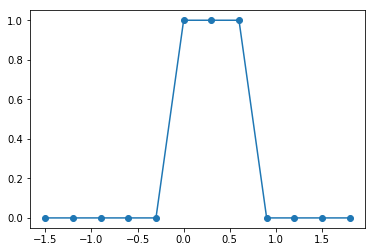

In [77]:
plt.plot(TEST_OFFSET_X_LIST, np.array(TEST_OFFSET_RES_LIST), '-o')

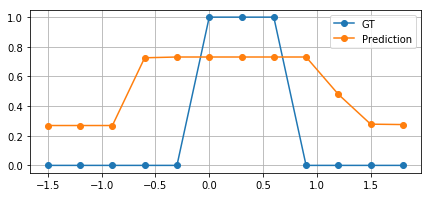

In [78]:
plt.figure(figsize=(7,3))
plt.plot(TEST_OFFSET_X_LIST, np.array(TEST_OFFSET_RES_LIST), '-o')
plt.plot(TEST_OFFSET_X_LIST, np.array(result_p), '-o')
plt.grid(True)
plt.legend(["GT", "Prediction"])

## test orientation offset

In [85]:
TEST_OFFSET_R_LIST = np.arange(-np.pi*0.6,np.pi*0.9+0.1,(np.pi*1.5)/11)
N_test = len(TEST_OFFSET_R_LIST)
TEST_OFFSET_RES_LIST = []
for i_test, TEST_OFFSET_R in enumerate(TEST_OFFSET_R_LIST):
    SAMPLED_DATA = defaultdict(dict)
    VISUALIZE = False
    MODEL_OFFSET_TEST = (1.5,1.5,0.75)

    #  GLOBAL
    CURRENT_PATH = os.path.join(DATA_PATH, DATASET)

    ## Load global params
    GLOBAL_PARAMS = load_json(os.path.join(CURRENT_PATH, GLOBAL_FILENAME))
    WDH = GLOBAL_PARAMS["WDH"]
    L_CELL = GLOBAL_PARAMS["L_CELL"]
    RATIO_DIMS = GLOBAL_PARAMS["RATIO_DIMS"]
    REACH_OFFSET_DICT = GLOBAL_PARAMS["REACH_OFFSET_DICT"]
    GRIPPER_REFS = GLOBAL_PARAMS["GRIPPER_REFS"]
    BASE_LINK = GLOBAL_PARAMS["BASE_LINK"]
    S_F_RATIO = GLOBAL_PARAMS["S_F_RATIO"]
    TIMEOUT = GLOBAL_PARAMS["TIMEOUT"]

    CENTER = tuple(np.divide(WDH, 2, dtype=np.float))
    Ws, Ds, Hs = WDH
    Nw, Nd, Nh = Nwdh = int(Ws / L_CELL), int(Ds / L_CELL), int(Hs / L_CELL)
    L_MAX = L_CELL * RATIO_DIMS
    print("scene size: {} ({},{},{})".format(Nw * Nd * Nh, Nw, Nd, Nh))

    # WORLD
    WORLD_PATH = os.path.join(CURRENT_PATH, WORLD)
    SAMPLED_DATA["WORLD"] = load_json(os.path.join(WORLD_PATH, WORLD_FILENAME))
    Trbt_dict = SAMPLED_DATA["WORLD"]["Trbt_dict"]
    for rkey in Trbt_dict:
        Trbt_dict[rkey][0] = np.subtract(Trbt_dict[rkey][0], MODEL_OFFSET_TEST)
    reach_center_dict = {k: tuple(np.add(v[0], REACH_OFFSET_DICT[k])) for k, v in Trbt_dict.items()}

    cam = None
    # set urdf
    xcustom, JOINT_NAMES, LINK_NAMES, urdf_content = set_custom_robots(crob.robots_on_scene, Trbt_dict,
                                                                       crob.custom_limits, start_rviz=VISUALIZE)
    ghnd = GeometryHandle(urdf_content)
    if VISUALIZE: time.sleep(2)

    # set graph
    graph = ConstraintGraph(ghnd=ghnd, urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES,
                            urdf_content=urdf_content, combined_robot=crob)
    graph.set_camera(cam)
    graph.set_cam_robot_collision(_add_cam_poles=False, color=(1, 1, 0, 0.3))
    if VISUALIZE: graph.set_rviz()

    # start UI
    ui_broker = UIBroker.instance()
    ui_broker.initialize(graph)
    ui_broker.start_server()

    # set rviz
    if VISUALIZE: graph.set_rviz(crob.home_pose)
    ui_broker.set_tables()

    for gripper in GRIPPER_REFS.values():
        graph.register_binder(name=gripper['bname'], _type=FramedTool, point=gripper['tcp_ref'], rpy=[0, 0, 0],
                              link_name=gripper['link_name'])
    graph.register_binder(name='base', _type=PlaceFrame, point=[0, 0, 0], rpy=[0, 0, 0], link_name=BASE_LINK)
    vtem = graph.ghnd.create_safe(name="virtual", gtype=GEOTYPE.SPHERE, link_name=BASE_LINK,
                                  dims=(0, 0, 0), center=(0, 0, 0), rpy=(0, 0, 0), collision=False, display=False
                                  )
    graph.add_object("virtual",
                     SingleHandleObject(_object=vtem,
                                        action_point=FramePoint(name="point", _object=vtem, point=(0, 0, 0),
                                                                rpy=(0, 0, 0), name_full=None)),
                     binding=("point", "base"))

    obj_list = []
    col_obj_list = []

    # SCENE
    SCENE_PATH = os.path.join(WORLD_PATH, SCENE)
    SAMPLED_DATA["SCENE"] = load_json(os.path.join(SCENE_PATH, SCENE_FILENAME))
    Q_s = np.array(SAMPLED_DATA["SCENE"]["Q_s"])
    Q_s, links, link_verts, link_ctems, link_rads = sample_joint(graph, Q_s_loaded=Q_s)
    Q_s_dict = SAMPLED_DATA["SCENE"]["Q_s_dict"]
    obj_dat = SAMPLED_DATA["SCENE"]["obj_dat"]

    if VISUALIZE:
        graph.show_pose(Q_s)
        time.sleep(1)
        graph.show_pose(Q_s)
        time.sleep(1)
        graph.show_pose(Q_s)
    for obj in obj_list: graph.remove_geometry(obj)
    for odat in obj_dat:
        nbox, gtype, dims, color, center, rpy = odat["nbox"], getattr(GEOTYPE, odat["gtype"]), odat["dims"], \
                                                odat["color"], odat["center"], odat["rpy"]
        center = np.subtract(center, MODEL_OFFSET_TEST)
        obj = graph.ghnd.create_safe(
            name="{}_{}_{}_{}".format(gtype.name, *nbox), link_name=BASE_LINK, gtype=gtype,
            center=center, rpy=rpy, dims=dims, color=color, display=True, collision=True, fixed=True)
        obj_list.append(obj)
        graph.add_marker(obj, vis=VISUALIZE)

    for obj in col_obj_list: graph.remove_geometry(obj)

    if VISUALIZE: graph.set_rviz()
    dcol = DataCollector(graph, GRIPPER_REFS, S_F_RATIO=S_F_RATIO)
    if VISUALIZE: graph.set_rviz()

    # ACTION
    print("[BEGIN] {} - {} - {} - {} ===============".format(DATASET, WORLD, SCENE, ACTION))
    snode_dict_bak = {int(k): v for k, v in load_json(os.path.join(SCENE_PATH, ACTION)).items()}
    dcol.snode_dict = dcol.manager.dict()
    for k, v in snode_dict_bak.items():
        dcol.snode_dict[k] = deepcopy(v)
    snode_keys = sorted(snode_dict_bak.keys())

    if i_act not in snode_keys:
        raise(RuntimeError("i_act not in snode_keys"))

    # snode
    snode = dcol.snode_dict[i_act]
    rname, inhand, obj, tar, dims_bak, color_bak, succ, _ = load_manipulation_from_dict(snode,
                                                                                        graph.ghnd)
    for gtem in [inhand, obj]:
        if gtem.link_name == BASE_LINK:
            gtem.set_offset_tf(center=np.subtract(gtem.center, MODEL_OFFSET_TEST))
            gtem.set_offset_tf(orientation_mat=np.matmul(gtem.orientation_mat, Rot_axis(2, TEST_OFFSET_R)))

    # action type
    if rname and tar:  # handover case
        action_type = "HANDOVER"
    elif inhand.collision:  # place case
        action_type = "PLACE"
    elif obj.collision:  # pick case
        action_type = "PICK"
    else:
        raise (RuntimeError("non-implemented case"))

    # planners
    if action_type == "HANDOVER":
        dual_mplan_dict = get_dual_planner_dict(GRIPPER_REFS, graph.ghnd, graph.urdf_content, graph.urdf_path,
                                                graph.link_names, graph.combined_robot.robot_names)
    else:
        mplan = MoveitPlanner(joint_names=graph.joint_names, link_names=graph.link_names, urdf_path=graph.urdf_path,
                              urdf_content=graph.urdf_content,
                              robot_names=graph.combined_robot.robot_names,
                              binder_links=[v.object.link_name for v in graph.binder_dict.values()],
                              ghnd=graph.ghnd)

    # plan
    if rname and tar:  # handover case
        remove_map = [[], [0, 1]]
        action_type = "HANDOVER"
        trajectory, Q_last, error, success_now = test_handover(graph, GRIPPER_REFS, rname, inhand,
                                                               obj, tar, Q_s,
                                                               dual_mplan_dict[(rname, tar)], timeout=TIMEOUT)
        state_s, state_g = get_handover_states(graph, GRIPPER_REFS, rname, inhand, obj, tar, Q_s)
    elif inhand.collision:  # place case
        remove_map = [[], [0, 1]]
        action_type = "PLACE"
        trajectory, Q_last, error, success_now = test_place(graph, GRIPPER_REFS, rname, inhand, obj,
                                                            tar, Q_s, mplan, timeout=TIMEOUT)
        state_s, state_g = get_place_states(graph, GRIPPER_REFS, rname, inhand, obj, tar, Q_s)
    elif obj.collision:  # pick case
        remove_map = [[1], [0]]
        action_type = "PICK"
        trajectory, Q_last, error, success_now = test_pick(graph, GRIPPER_REFS, rname, inhand, obj,
                                                           tar, Q_s, mplan, timeout=TIMEOUT)
        state_s, state_g = get_pick_states(graph, GRIPPER_REFS, rname, inhand, obj, tar, Q_s)
    else:
        remove_map = [[], [0,1]]
        action_type = "None"
        raise (RuntimeError("non-implemented case"))

    if VISUALIZE:
        show_manip_coords(graph, GRIPPER_REFS, action_type, rname, inhand, obj, rname2=tar)
#         graph.show_motion(trajectory, period=0.1)

    print("[END] {} - {} - {} - {} - {} = {} / {} ({}/{})".format(DATASET, WORLD, SCENE, ACTION, i_act, success_now, succ, i_test, N_test), end='\r')
    TEST_OFFSET_RES_LIST.append(success_now)
    
    # convert_send scene
    gtimer.reset()
    gtimer.tic("convert_workspace")
    ghnd_new= graph.convert_workspace(ghnd)
    gtimer.toc("convert_workspace")

    ## remove bases
    exclude_list = ["floor", "wall", "cam"]
    gkeys = sorted(ghnd_new.NAME_DICT.keys())
    for gname in gkeys:
        gtem = ghnd_new.NAME_DICT[gname]
        if np.any([ename in gtem.name for ename in exclude_list]):
            ghnd_new.remove(gtem)
    graph.object_list=[]
    from_state = state_s
    to_state = state_g
    gtimer.tic("convert_scene")
    scene_base_data, ctem_names, ctem_cells, chain_dict = graph.convert_scene(ghnd_new, state=from_state, only_base=False)
    gtimer.toc("convert_scene")
    gtimer.tic("copy_scene_base_data")
    scene_base_batch_p[i_test] = scene_base_data
    gtimer.toc("copy_scene_base_data")
    print(ghnd_new.NAME_DICT.keys())

    # convert_send action
    from pkg.planner.moveit.moveit_planner import MoveitPlanner
    mplan = MoveitPlanner(joint_names=graph.joint_names, link_names=graph.link_names, urdf_path=graph.urdf_path, urdf_content=graph.urdf_content,
                          robot_names=graph.combined_robot.robot_names, binder_links=[v.object.link_name for v in graph.binder_dict.values()], ghnd=graph.ghnd)
    graph.set_planner(mplan)
    from pkg.sampler.object_a_star import *
    sampler = ObjectAstarSampler(graph)
    graph.set_sampler(sampler)
    sampler.build_graph()

    state = from_state
    leaf = sampler.node_dict[state.onode][0]
    Q_dict = list2dict(state.Q, graph.joint_names)

    gtimer.reset()
    cell_init_b, verts_init_b, chain_init_b, cell_goal_b, verts_goal_b, chain_goal_b = [], [], [], [], [], []
    gtimer.tic("get_action_boxes")
    cell_init, verts_init, chain_init, cell_goal, verts_goal, chain_goal = get_action_boxes(
        graph, from_state, to_state, {}, mplan=mplan, L_CELL=0.2, Nwdh=(15,15,15), BASE_LINK='base_link')
    gtimer.toc("get_action_boxes")

    cell_init_p[i_test,:] = cell_init
    verts_init_p[i_test,:] = verts_init
    chain_init_p[i_test,:] = chain_init
    cell_goal_p[i_test,:] = cell_goal
    verts_goal_p[i_test,:] = verts_goal
    chain_goal_p[i_test,:] = chain_goal
if VISUALIZE: graph.show_pose(Q_s)

scene size: 3375 (15,15,15)


Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = False / True (0/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'pa

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = False / True (1/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'pa

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = False / True (2/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'pa

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = False / True (3/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'pa

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = True / True (4/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'pan

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = True / True (5/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'pan

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = True / True (6/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'pan

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = True / True (7/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'pan

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = False / True (8/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'pa

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = False / True (9/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'pa

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = False / True (10/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'p

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


[BEGIN] 20201216-021416 - WORLD-20201216-052332 - SCENE-20201216-052334 - 20201216-052400.json ===============
ignore CYLINDER_4_14_2 out of workspace052332 - SCENE-20201216-052334 - 20201216-052400.json - 0 = False / True (11/12)
['CYLINDER_12_9_3', 'BOX_7_14_6', 'BOX_3_13_7', 'CYLINDER_1_6_11', 'BOX_4_10_9', 'indy0_link5_Cylinder_0', 'BOX_3_1_6', 'panda1_leftfinger_Cylinder_0', 'BOX_3_11_3', 'CYLINDER_12_11_1', 'BOX_12_7_5', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_5_12_1', 'CYLINDER_4_3_10', 'BOX_9_9_10', 'BOX_8_12_7', 'BOX_7_10_0', 'CYLINDER_3_8_4', u'BOX_7_10_3', 'BOX_7_10_5', 'panda1_rightfinger_Cylinder_0', 'BOX_9_7_10', 'BOX_9_8_1', 'CYLINDER_10_14_4', 'BOX_11_10_4', 'panda1_link2_Cylinder_0', 'CYLINDER_4_12_8', 'BOX_2_10_11', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_12_8_2', 'BOX_3_8_9', 'indy0_tcp_Cylinder_0_1', 'BOX_3_0_5', 'BOX_8_4_10', 'BOX_11_8_8', 'CYLINDER_11_10_11', 'CYLINDER_5_0_6', 'BOX_0_7_3', 'panda1_link6_Cylinder_1', 'p

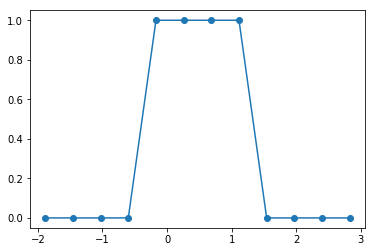

In [86]:
plt.plot(TEST_OFFSET_R_LIST, np.array(TEST_OFFSET_RES_LIST), '-o')

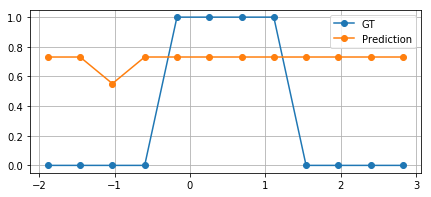

In [87]:
plt.figure(figsize=(7,3))
plt.plot(TEST_OFFSET_R_LIST, np.array(TEST_OFFSET_RES_LIST), '-o')
plt.plot(TEST_OFFSET_R_LIST, np.array(result_p), '-o')
plt.grid(True)
plt.legend(["GT", "Prediction"])

# Test code one-by-one

## convert world

In [14]:
gtimer.reset()
gtimer.tic("convert_workspace")
ghnd_new= graph.convert_workspace(ghnd)
gtimer.toc("convert_workspace")

## remove bases
exclude_list = ["floor", "wall", "cam"]
gkeys = sorted(ghnd_new.NAME_DICT.keys())
for gname in gkeys:
    gtem = ghnd_new.NAME_DICT[gname]
    if np.any([ename in gtem.name for ename in exclude_list]):
        ghnd_new.remove(gtem)

ignore BOX_1_3_0 out of workspace
ignore BOX_12_0_6 out of workspace
ignore CYLINDER_14_5_4 out of workspace
ignore CYLINDER_14_2_9 out of workspace
ignore CYLINDER_0_6_10 out of workspace
ignore CYLINDER_6_0_8 out of workspace


## convert & send scene

In [15]:
graph.object_list=[]
from_state = state_s
to_state = state_g
gtimer.tic("convert_scene")
scene_base_data, ctem_names, ctem_cells, chain_dict = graph.convert_scene(ghnd_new, state=from_state, only_base=False)
gtimer.toc("convert_scene")
gtimer.tic("copy_scene_base_data")
np.copyto(scene_base_data_p, scene_base_data)
gtimer.toc("copy_scene_base_data")
print(ghnd_new.NAME_DICT.keys())

['CYLINDER_14_2_0', 'CYLINDER_12_9_6', 'CYLINDER_5_3_1', 'CYLINDER_12_9_5', 'BOX_11_9_7', 'BOX_11_9_6', 'CYLINDER_6_6_7', 'CYLINDER_6_1_2', 'indy0_link5_Cylinder_0', 'CYLINDER_6_8_6', 'panda1_leftfinger_Cylinder_0', 'panda1_link5_Cylinder_0', 'panda1_link5_Cylinder_1', 'panda1_hand_Cylinder_0', 'CYLINDER_12_4_2', 'CYLINDER_3_4_1', 'CYLINDER_3_13_8', 'CYLINDER_5_12_8', 'CYLINDER_12_6_7', 'BOX_11_12_4', 'CYLINDER_8_4_2', 'panda1_rightfinger_Cylinder_0', 'BOX_9_8_2', 'BOX_2_11_5', 'BOX_11_10_4', 'BOX_1_11_8', 'BOX_11_6_0', 'panda1_link2_Cylinder_0', 'indy0_tcp_Cylinder_2_3', 'CYLINDER_4_12_1', 'BOX_3_6_8', 'CYLINDER_12_8_4', 'BOX_6_7_6', 'indy0_tcp_Cylinder_0_1', 'CYLINDER_13_11_2', 'BOX_4_11_1', 'BOX_8_0_4', 'CYLINDER_11_9_6', 'BOX_12_6_2', 'BOX_3_10_7', 'CYLINDER_8_9_0', 'CYLINDER_8_9_3', 'panda1_link6_Cylinder_1', 'panda1_link6_Cylinder_0', 'panda1_link6_Cylinder_2', 'CYLINDER_0_10_2', 'BOX_11_11_7', 'panda1_link3_Cylinder_0', 'indy0_link2_Cylinder_0_000', 'indy0_link2_Cylinder_0_001',

## convert & send action

In [16]:
from pkg.planner.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(joint_names=graph.joint_names, link_names=graph.link_names, urdf_path=graph.urdf_path, urdf_content=graph.urdf_content,
                      robot_names=graph.combined_robot.robot_names, binder_links=[v.object.link_name for v in graph.binder_dict.values()], ghnd=graph.ghnd)
graph.set_planner(mplan)
from pkg.sampler.object_a_star import *
sampler = ObjectAstarSampler(graph)
graph.set_sampler(sampler)
sampler.build_graph()

state = from_state
leaf = sampler.node_dict[state.onode][0]
Q_dict = list2dict(state.Q, graph.joint_names)

In [18]:
gtimer.reset()
BATCH_SIZE = 12
cell_init_b, verts_init_b, chain_init_b, cell_goal_b, verts_goal_b, chain_goal_b = [], [], [], [], [], []
for _ in range(BATCH_SIZE):
    gtimer.tic("get_action_boxes")
    cell_init, verts_init, chain_init, cell_goal, verts_goal, chain_goal = get_action_boxes(
        graph, from_state, to_state, {}, mplan=mplan, L_CELL=0.2, Nwdh=(15,15,15), BASE_LINK='base_link')
    cell_init_b.append(cell_init)
    verts_init_b.append(verts_init)
    chain_init_b.append(chain_init)
    cell_goal_b.append(cell_goal)
    verts_goal_b.append(verts_goal)
    chain_goal_b.append(chain_goal)
    gtimer.toc("get_action_boxes")
cell_init_b = np.array(cell_init_b)
verts_init_b = np.array(verts_init_b)
chain_init_b = np.array(chain_init_b)
cell_goal_b = np.array(cell_goal_b)
verts_goal_b = np.array(verts_goal_b)
chain_goal_b = np.array(chain_goal_b)

In [19]:
np.copyto(cell_init_p, cell_init_b)
np.copyto(verts_init_p, verts_init_b)
np.copyto(chain_init_p, chain_init_b)
np.copyto(cell_goal_p, cell_goal_b)
np.copyto(verts_goal_p, verts_goal_b)
np.copyto(chain_goal_p, chain_goal_b)

In [74]:
centers = get_centers(Nwdh, L_CELL)-(1.5,1.5,H_MEAN)
#centers = get_centers(Nwdh, L_CELL)
for idx, center, cell_dat in zip(range(Nwdh[0]*Nwdh[1]*Nwdh[2]), centers.reshape((-1,3)), scene_data.reshape((-1, scene_data.shape[-1]))):
    gtem, mask, chain = get_box_diplay(ghnd, "box_{}".format(idx), cell_dat, 0, joint_num, center)
    if mask:
        graph.add_marker(gtem)
    gtem, mask, chain = get_cyl_diplay(ghnd, "cyl_{}".format(idx), cell_dat, N_BEGIN_CYL, joint_num, center)
    if mask:
        graph.add_marker(gtem)
    gtem, mask, chain = get_box_diplay(ghnd, "init_{}".format(idx), cell_dat, N_BEGIN_INIT, joint_num, center, color=(0,0,0,0.8))
    if mask:
        graph.add_marker(gtem)
    gtem, mask, chain = get_box_diplay(ghnd, "goal_{}".format(idx), cell_dat, N_BEGIN_GOAL, joint_num, center, color=(0.8,0.8,0.8,0.8))
    if mask:
        graph.add_marker(gtem)

In [73]:

for idx, center, cell_dat in zip(range(Nwdh[0]*Nwdh[1]*Nwdh[2]), centers.reshape((-1,3)), scene_data.reshape((-1, scene_data.shape[-1]))):
    gtem, mask, chain = get_box_diplay(ghnd, "box_{}".format(idx), cell_dat, 0, joint_num, center)
    if mask:
        graph.remove_geometry(gtem)
    gtem, mask, chain = get_cyl_diplay(ghnd, "cyl_{}".format(idx), cell_dat, N_BEGIN_CYL, joint_num, center)
    if mask:
        graph.remove_geometry(gtem)
    gtem, mask, chain = get_box_diplay(ghnd, "init_{}".format(idx), cell_dat, N_BEGIN_INIT, joint_num, center, color=(0,0,0,0.8))
    if mask:
        graph.remove_geometry(gtem)
    gtem, mask, chain = get_box_diplay(ghnd, "goal_{}".format(idx), cell_dat, N_BEGIN_GOAL, joint_num, center, color=(0,0,0,0.8))
    if mask:
        graph.remove_geometry(gtem)